In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import random
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image, ImageChops, ImageEnhance
from IPython.display import display # to display images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_original = '/content/drive/My Drive/training/pristine/'
path_tampered = '/content/drive/My Drive/training/fake/'

total_orig = os.listdir(path_original)
total_tampered = os.listdir(path_tampered)

In [ ]:
total_tampered.remove('.DS_Store')

In [ ]:
len(total_orig),len(total_tampered)

(1050, 900)


In [ ]:
images = []
for file in tqdm(total_orig):  #choose all pristine
    try:
        if file.endswith('png'):
                line = path_original + file  + ',0\n'
                images.append(line)
    except:
        print(path_original+file)
        
for file in tqdm(total_tampered):       #choose all tampered images
    try:
        if file.endswith('png'):
                    line = path_tampered + file + ',1\n'
                    images.append(line)

    except:
          print(path_tampered+file)

In [ ]:
X_f = []
Y_f = []

In [ ]:
image_name = []
label = []
for i in tqdm(range(len(images))):
    image_name.append(images[i][0:-3])
    label.append(images[i][-2])

In [ ]:
dataset = pd.DataFrame({'image':image_name,'class_label':label})

In [ ]:
dataset.head(10)

,image,class_label
0,/content/drive/My Drive/training/pristine/6d11...,0
1,/content/drive/My Drive/training/pristine/3c96...,0
2,/content/drive/My Drive/training/pristine/0d6d...,0
3,/content/drive/My Drive/training/pristine/1b28...,0
4,/content/drive/My Drive/training/pristine/4bc6...,0
5,/content/drive/My Drive/training/pristine/6d96...,0
6,/content/drive/My Drive/training/pristine/5c93...,0
7,/content/drive/My Drive/training/pristine/3b15...,0
8,/content/drive/My Drive/training/pristine/6b90...,0
9,/content/drive/My Drive/training/pristine/1bf6...,0


In [ ]:
dataset.shape

(1950,2)


Text(0.5, 1.0, 'Images belomging to each class')

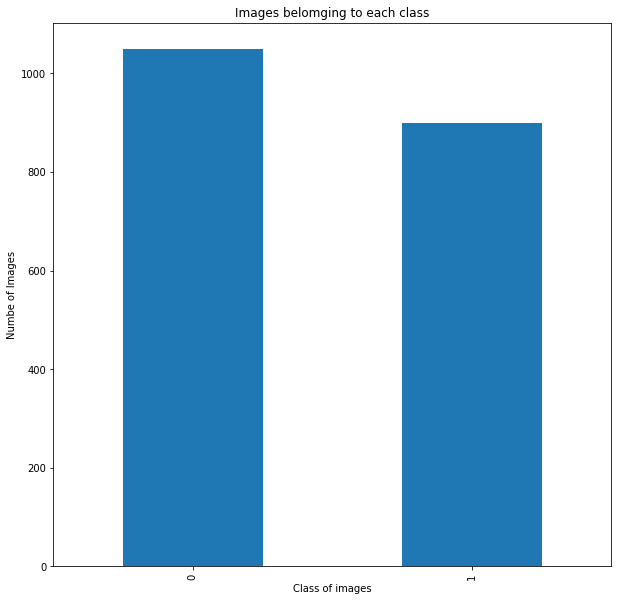

In [ ]:
plt.figure(figsize = (10,10))
k = dataset['class_label'].value_counts()
k.plot(kind = 'bar')
plt.xlabel("Class of images")
plt.ylabel("Numbe of Images")
plt.title("Images belomging to each class")

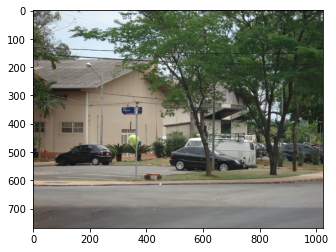

In [ ]:
x=Image.open(dataset['image'][1200])
plt.imshow(x)

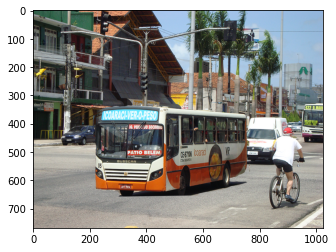

In [ ]:
x=Image.open(dataset['image'][1300])
plt.imshow(x)

In [ ]:
def abcd(img_path):
  original=Image.open(img_path)
  return original

In [ ]:
for index, row in tqdm(dataset.iterrows()):
    X_f.append(np.array(abcd(row[0]))
    Y_f.append(row[1])
x_casia = np.array(X_f)
y_casia = np.array(Y_f)

1950it [01:20, 18.67it/s]


In [ ]:
x_casia = x_casia.reshape(-1, 128, 128, 3)
y_casia = to_categorical(y_casia, 2)

In [ ]:
import numpy as np
import os
import tensorflow as tf
data_dir='/content/drive/My Drive/folder'
batch_size = 32
img_height = 128
img_width = 128

In [ ]:
list_ds = tf.data.dataset.list_files(str(data_dir + "*/*"+"*/*"), shuffle=False)
image_count=0
for dir1 in os.listdir(data_dir):
    for files in os.listdir(os.path.join(data_dir, dir1)):
        image_count+=1
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True)
class_names = np.array(sorted([dir1 for dir1 in os.listdir(data_dir)]))


In [ ]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)


In [ ]:
def get_label(file_path):
  # convert the path to a list of path components separated by sep
  parts = tf.strings.split(file_path, os.path.sep)
  
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
# Integer encode the label
  return tf.argmax(tf.cast(one_hot, tf.int32))
# To process the image
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])
# To create the single training of validation example with image and its corresponding label
def process_path(file_path):
  label = get_label(file_path)
# load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [ ]:
%load_ext tensorboard
from keras.callbacks import TensorBoard
import datetime
# + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir="logs" 
tensorboard_callback = TensorBoard(log_dir=log_dir)

In [ ]:
mcp_save = ModelCheckpoint('model_1.h5', save_best_only=True, monitor='val_loss', mode='min')

In [4]:
model=tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(128, 128, 3)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Dropout(0.5)
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense()
         ])
#Compile the model
optimizer = Adam()

model.compile(optimizer=optimizer, loss='binary_crossentropy',
metrics=['accuracy'])
#Fitting the model
history = model.fit(train_ds,validation_data=val_ds,epochs=30,initial_epoch = 0,batch_size=10,verbose=1,callbacks=[tensorboard_callback,mcp_save])

Epoch 1/30
37/37 [==============================] - 24s 654ms/step - loss: 0.4410 - accuracy: 0.6870 - val_loss: 0.5781 - val_accuracy: 0.7656
6Epoch 2/30
37/37 [==============================] - 21s 567ms/step - loss: 0.3460 - accuracy: 0.6891 - val_loss: 0.5347 - val_accuracy: 0.7487
Epoch 3/30
37/37 [==============================] - 21s 566ms/step - loss: 0.3062 - accuracy: 0.6909 - val_loss: 0.4093 - val_accuracy: 0.7584
Epoch 4/30
37/37 [==============================] - 21s 565ms/step - loss: 0.2844 - accuracy: 0.6978 - val_loss: 0.2672 - val_accuracy: 0.7587
Epoch 5/30
37/37 [==============================] - 21s 566ms/step - loss: 0.2722 - accuracy: 0.6998 - val_loss: 0.2814 - val_accuracy: 0.7545
Epoch 6/30
37/37 [==============================] - 21s 565ms/step - loss: 0.2657 - accuracy: 0.7076 - val_loss: 0.2200 - val_accuracy: 0.7468
Epoch 7/30
37/37 [==============================] - 21s 567ms/step - loss: 0.2603 - accuracy: 0.7134 - val_loss: 0.2133 - val_accuracy: 0.723

In [ ]:
%tensorboard --logdir /content/logs

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
y_pred_cnn = model.predict(x_casia)
y_pred_cnn = np.argmax(y_pred_cnn,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_casia,axis = 1) 

score = metrics.precision_score(Y_true,y_pred_cnn, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(Y_true, y_pred_cnn, average= "weighted")
print("Recall score: {}".format(score))
score_lr1 = metrics.f1_score(Y_true, y_pred_cnn, average= "weighted")
print("F1 score: {}".format(score_lr1))

Precision score: 0.7064202579427493 
Recall score: 0.7280968475967 
F1 score: 0.7037969007321574 


In [ ]:
mcp_save = ModelCheckpoint('model_1.h5', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
model=tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(128, 128, 3)),
            tf.keras.applications.VGG16(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(6)
         ])
#Compile the model
optimizer = Adam()

model.compile(optimizer=optimizer, loss='binary_crossentropy',
metrics=['accuracy'])
#Fitting the model
history = model.fit(train_ds,validation_data=val_ds,epochs=30,initial_epoch = 0,batch_size=10,verbose=1,callbacks=[tensorboard_callback,mcp_save])

Epoch 1/30
37/37 [==============================] - 24s 654ms/step - loss: 0.4410 - accuracy: 0.6870 - val_loss: 0.5781 - val_accuracy: 0.7656
6Epoch 2/30
37/37 [==============================] - 21s 567ms/step - loss: 0.3460 - accuracy: 0.6891 - val_loss: 0.5347 - val_accuracy: 0.7487
Epoch 3/30
37/37 [==============================] - 21s 566ms/step - loss: 0.3062 - accuracy: 0.6909 - val_loss: 0.4093 - val_accuracy: 0.7584
Epoch 4/30
37/37 [==============================] - 21s 565ms/step - loss: 0.2844 - accuracy: 0.6978 - val_loss: 0.2672 - val_accuracy: 0.7587
Epoch 5/30
37/37 [==============================] - 21s 566ms/step - loss: 0.2796 - accuracy: 0.6992 - val_loss: 0.2453 - val_accuracy: 0.7424
Epoch 6/30
37/37 [==============================] - 21s 565ms/step - loss: 0.2657 - accuracy: 0.7076 - val_loss: 0.2200 - val_accuracy: 0.7468
Epoch 7/30
37/37 [==============================] - 21s 567ms/step - loss: 0.2603 - accuracy: 0.7134 - val_loss: 0.2133 - val_accuracy: 0.723

In [ ]:
%tensorboard --logdir /content/logs

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
y_pred_cnn = model.predict(x_casia)
y_pred_cnn = np.argmax(y_pred_cnn,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_casia,axis = 1) 

score = metrics.precision_score(Y_true,y_pred_cnn, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(Y_true, y_pred_cnn, average= "weighted")
print("Recall score: {}".format(score))
score_lr1 = metrics.f1_score(Y_true, y_pred_cnn, average= "weighted")
print("F1 score: {}".format(score_lr1))

Precision score: 0.7505456451 
Recall score: 0.7856256154 
F1 score: 0.73358526 


In [ ]:
mcp_save = ModelCheckpoint('model_1.h5', save_best_only=True, monitor='val_loss', mode='min')

In [5]:
model=tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(128, 128, 3)),
            tf.keras.applications.ResNet50(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(6)
         ])
#Compile the model
optimizer = Adam()

model.compile(optimizer=optimizer, loss='binary_crossentropy',
metrics=['accuracy'])
#Fitting the model
history = model.fit(train_ds,validation_data=val_ds,epochs=30,initial_epoch = 0,batch_size=10,verbose=1,callbacks=[tensorboard_callback,mcp_save])

Epoch 1/30
37/37 [==============================] - 24s 654ms/step - loss: 0.4410 - accuracy: 0.6870 - val_loss: 0.5781 - val_accuracy: 0.7656
6Epoch 2/30
37/37 [==============================] - 21s 567ms/step - loss: 0.3460 - accuracy: 0.6891 - val_loss: 0.5347 - val_accuracy: 0.7487
Epoch 3/30
37/37 [==============================] - 21s 566ms/step - loss: 0.3062 - accuracy: 0.6909 - val_loss: 0.4093 - val_accuracy: 0.7584
Epoch 4/30
37/37 [==============================] - 21s 565ms/step - loss: 0.2844 - accuracy: 0.6978 - val_loss: 0.2672 - val_accuracy: 0.7587
Epoch 5/30
37/37 [==============================] - 21s 566ms/step - loss: 0.2722 - accuracy: 0.6998 - val_loss: 0.2814 - val_accuracy: 0.7545
Epoch 6/30
37/37 [==============================] - 21s 565ms/step - loss: 0.2657 - accuracy: 0.7076 - val_loss: 0.2200 - val_accuracy: 0.7468
Epoch 7/30
37/37 [==============================] - 21s 567ms/step - loss: 0.2603 - accuracy: 0.7134 - val_loss: 0.2133 - val_accuracy: 0.723

In [ ]:
%tensorboard --logdir /content/logs

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
y_pred_cnn = r_model.predict(x_casia)
y_pred_cnn = np.argmax(y_pred_cnn,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_casia,axis = 1) 

score = metrics.precision_score(Y_true,y_pred_cnn, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(Y_true, y_pred_cnn, average= "weighted")
print("Recall score: {}".format(score))
score_lr1 = metrics.f1_score(Y_true, y_pred_cnn, average= "weighted")
print("F1 score: {}".format(score_lr1))

Precision score: 0.7164705882352941 
Recall score: 0.7956452575781 
F1 score: 0.70358526 


In [ ]:
from prettytable import PrettyTable 
  
myTable = PrettyTable(["Model", "Precision", "Recall", "F1 score"]) 
myTable.add_row(["Random CNN Model", " 0.7064202579427493", "0.0.7037969007321574", "0.728968475967"]) 
myTable.add_row(["Vgg16", "0.7505456451", "0.7856256154", "0.73358526"]) 
myTable.add_row(["Resnet", "0.7164705882352941", "0.7956452575781", "0.70358526"]) 
  
print(myTable)

+------------------+---------------------+----------------------+----------------+
|      Model       |      Precision      |        Recall        |    F1 score    |
+------------------+---------------------+----------------------+----------------+
| Random CNN Model |  0.7064202579427493 | 0.0.7037969007321574 | 0.728968475967 |
|      Vgg16       |     0.7505456451    |     0.7856256154     |   0.73358526   |
|      Resnet      |  0.7164705882352941 |   0.7956452575781    |   0.70358526   |
+------------------+---------------------+----------------------+----------------+
